[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabrielkasmi/ot_gan_ensae/blob/master/autodiff_ot_gan.ipynb)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
!pip install torchviz #git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=f9344063ac4321824970c5473267843e8dc586e27bb504974e856c7c69a8e93d
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
cuda = torch.cuda.is_available()


The model for the MLP is the same as in the paper. Two input neurons, a hidden layer with 500 units and an output layer with 784 units. We choose the ReLU activation function.

In [0]:
class MultilayerPerceptron(nn.Module):
    """
    A MLP with 1 hidden layer
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
    Constructor of the MLP.
    Arguments:
    - input_size : number of neurons in the first layer 
    (aka latent space dimension)
    - hidden_size : number of neurons in the hidden layer
    - outout_size : number of neurons in the last layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        # self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        hidden = self.hidden(x)
        relu = self.relu(hidden)
        output = self.output(relu)
        # output = self.sigmoid(output)
        # output = self.relu(output)
        return output
    

In [4]:
test = MultilayerPerceptron(2, 500, 784)
print(test)

MultilayerPerceptron(
  (hidden): Linear(in_features=2, out_features=500, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=500, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


In [0]:
make_dot(test.forward(x)).render('img/mlp_architecture')

'img/mlp_architecture.pdf'

In [0]:
x = torch.rand(2, requires_grad=True)
y_random = test.forward(x)

In [0]:
def imshow(img):
    """
    takes a tensor as input and returns an image
    """
    if cuda:
      np_img = img.detach().cpu().numpy()
    else:
      np_img = img.detach().numpy()
    plt.imshow(np.reshape(np_img,(28,28)), cmap='gray_r' )
    plt.show()

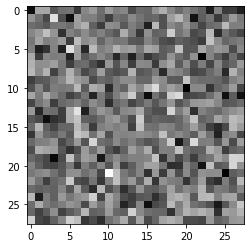

In [7]:
# for i in range(10):
#     imshow(test.forward(x[i,:]))
imshow(test.forward(x))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


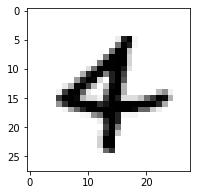

In [8]:
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)



# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 512

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images_np = images.numpy()


# get one image from the batch
img = np.squeeze(images_np[np.random.randint(len(images))])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray_r')
plt.show()

In [0]:
img_test = images[0]

cuda = torch.cuda.is_available()
                                 
if cuda:  
  test = MultilayerPerceptron(2, 500, 784).cuda()

In [0]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(test.parameters(), lr = 0.02) # same optimizer as in the paper

In [11]:
# test if the network is training as expected on a dummy example
# should generate an "average" image

z_size = 2
test.train()
epochs = 10 # not necesasry to put many epochs
samples_evolution = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        #real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28).cuda()
                
        optimizer.zero_grad()
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = test(z).cuda()
            
        # Compute Loss 
        loss = criterion(y_pred, real_images) # this loss will be replaced by the sinkhorn loss
   
        
        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=True).cuda()
        samples_evolution.append(test(x))

Epoch 0: train loss: 0.25800
Generating an image after 0 epochs
Epoch 1: train loss: 0.25900
Epoch 2: train loss: 0.26435
Epoch 3: train loss: 0.29695
Epoch 4: train loss: 0.28566
Epoch 5: train loss: 0.28568
Epoch 6: train loss: 0.26543
Epoch 7: train loss: 0.26350
Epoch 8: train loss: 0.26063
Epoch 9: train loss: 0.25681


In [11]:
for img in samples_evolution:
    imshow(img)

NameError: ignored

In [0]:
imshow(samples_evolution[-1])
# plt.savefig("img/training_L2_loss.png")

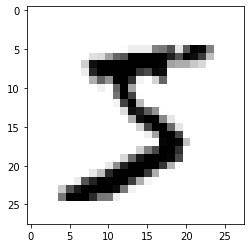

In [0]:
# for i in range(10):
#     imshow(img_test[i])
imshow(img_test)

In [0]:
def cost_matrix(mu,nu):
    """
    computes the cost matrix between two distributions of size n
    with d points each
    
    norm : l2 norm
    
    returns a cost matrix of size n*n
    """
    
    # sizes and reshape the tensors
    bs, n = mu.size()
    bs2, m = nu.size()
    
    x_reshape = mu.view(n, bs)
    y_reshape = nu.view(m, bs2)

    if cuda:
    
      # clone the tensors
      x_i = torch.clone(x_reshape[:, None]).requires_grad_(True).cuda()
      y_j = torch.clone(y_reshape[None,:]).requires_grad_(True).cuda()

    else:
      # clone the tensors
      x_i = torch.clone(x_reshape[:, None]).requires_grad_(True)
      y_j = torch.clone(y_reshape[None,:]).requires_grad_(True)

    
    if cuda:
      C = ((x_i - y_j) ** 2).sum(-1).cuda()
      return C/C.max()
    else:
      C = ((x_i - y_j) ** 2).sum(-1)
      return C/C.max()

def sinkhorn_wasserstein(x, y, C, epsilon=1., max_iters = 50):
    """
    uses sinkhorn algorithm to approximate the optimal
    transport plan between two input measures x and y.
    
    computes the cost matrix (l2 norm) and alternate
    projections to compute the 
    """
    
    # compute the empirical distributions over the batches
    x_mean = x.view(784, -1).mean(1, keepdim=False).cuda()
    x_mean = x_mean / x_mean.max()
    y_mean = y.view(784, -1).mean(1, keepdim=False).cuda()
    y_mean = y_mean / y_mean.max()
           
    # Compute the kernel matrix K
    K = torch.exp(-C/epsilon).cuda()
    
    # Alternate projections
    v = torch.ones(y_mean.size()).cuda()
    
    if cuda:
      for _ in range(max_iters):
          u = x_mean / torch.mv(K,v).cuda()
          u = u / u.max()
          v = y_mean / torch.mv(K.t(),u).cuda()
          v = v / v.max()
    else:
        for _ in range(max_iters):
          u = x_mean / torch.mv(K,v) 
          v = y_mean / torch.mv(K.t(),u) 

        
    diag_u = torch.diag(u)
    diag_v = torch.diag(v)
    u_dot_K = torch.mm(diag_u,K)
    
    # Approximation of the optimal transport plan
    P_L = torch.mm(u_dot_K,diag_v)
    
    # Approximation of the Wasserstein Loss
    W_L = torch.trace(torch.mm(P_L.t(),C))
    
    return W_L


def sinkhorn_loss(x,y, epsilon = 1., max_iters = 50):
    """
    returns the sinkhorn loss
    """
    # cost matrices
    C_xx, C_xy, C_yy = cost_matrix(x,x), cost_matrix(x,y), cost_matrix(y,y)
    
    # wasserstein losses 
    W_xx = sinkhorn_wasserstein(x,x, C_xx, epsilon = epsilon, max_iters = max_iters)
    W_xy = sinkhorn_wasserstein(x,y, C_xy, epsilon = epsilon, max_iters = max_iters)
    W_yy = sinkhorn_wasserstein(y,y, C_yy, epsilon = epsilon, max_iters = max_iters)
    
    
    return 2 * W_xy - W_xx - W_yy

In [0]:
cuda = torch.cuda.is_available()
                                 
if cuda:  
  model = MultilayerPerceptron(2, 500, 784).cuda()


In [73]:
C_11 = cost_matrix(y_pred, y_pred)
print(sinkhorn_wasserstein(y_pred,y_pred, C_11))
#C_22 = cost_matrix(real_images, real_images)
#print(sinkhorn_wasserstein(real_images,real_images, C_22))
C_12 = cost_matrix(y_pred, real_images)
print(sinkhorn_wasserstein(y_random,real_images, C_12, epsilon = 1))
#print(W_xx = sinkhorn_wasserstein(x,x, C_xx, epsilon = epsilon, max_iters = max_iters))
#print(W_xy = sinkhorn_wasserstein(x,y, C_xy, epsilon = epsilon, max_iters = max_iters))
#print(W_yy = sinkhorn_wasserstein(y,y, C_yy, epsilon = epsilon, max_iters = max_iters))

tensor(-175.0451, device='cuda:0', grad_fn=<TraceBackward>)
tensor(nan, device='cuda:0', grad_fn=<TraceBackward>)


In [15]:
# training with custom loss

z_size = 2
batch_size = 32
model.train()
epochs = 50
samples_evolution_sk = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        with torch.no_grad():
          batch_size = real_images.size(0)
          #real_images = real_images*2 - 1 # rescale the images
          real_images = real_images.view(-1, 28*28)
          if cuda : 
            real_images.cuda()
                
          optimizer.zero_grad()
        
          # Forward pass
          z = torch.rand((batch_size,z_size), requires_grad=True)
          if cuda :
            z = z.cuda()

          y_pred = model(z)
            
          # Compute Loss 
          loss = sinkhorn_loss(y_pred, real_images, epsilon = 1) 

        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=True).cuda()
        samples_evolution_sk.append(model(x))

Epoch 0: train loss: -824.13965
Generating an image after 0 epochs
Epoch 1: train loss: -3947.20020
Epoch 2: train loss: -863.34741
Epoch 3: train loss: 203.77002
Epoch 4: train loss: -544.33594
Epoch 5: train loss: 1755.68604
Epoch 6: train loss: -754.85400
Epoch 7: train loss: -964.14380
Epoch 8: train loss: 240.99316
Epoch 9: train loss: -1179.80518
Epoch 10: train loss: -480.49146
Generating an image after 10 epochs
Epoch 11: train loss: -647.14600
Epoch 12: train loss: 1348.82471
Epoch 13: train loss: -374.34424
Epoch 14: train loss: -709.23315
Epoch 15: train loss: -1233.71411
Epoch 16: train loss: -290.43066
Epoch 17: train loss: -1854.95874
Epoch 18: train loss: -648.99146
Epoch 19: train loss: -208.64648
Epoch 20: train loss: 359.43994
Generating an image after 20 epochs
Epoch 21: train loss: 10.87695
Epoch 22: train loss: -741.14209
Epoch 23: train loss: -780.03809
Epoch 24: train loss: -7263.59375
Epoch 25: train loss: -451.29492
Epoch 26: train loss: -1373.18945
Epoch 27: t

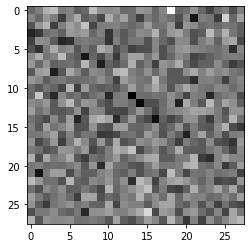

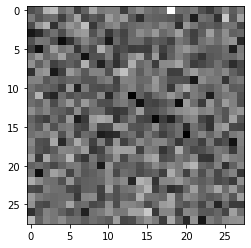

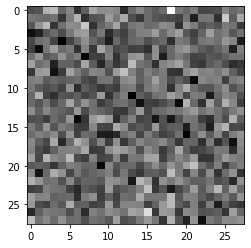

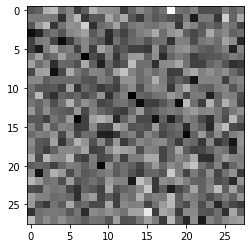

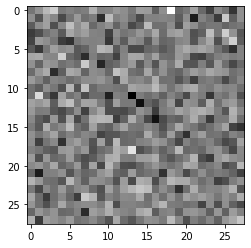

In [16]:
for img in samples_evolution_sk:
    imshow(img)

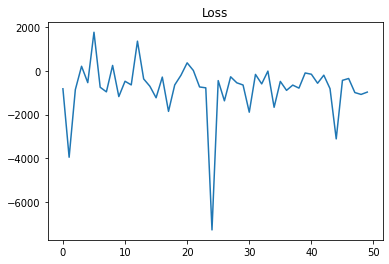

In [31]:
plt.plot(np.array(losses))
plt.title('Loss')
plt.savefig('loss_first_trial.png')

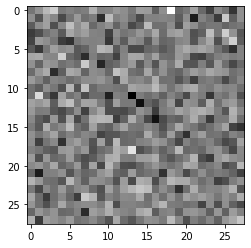

<Figure size 432x288 with 0 Axes>

In [34]:
imshow(samples_evolution_sk[-1])
plt.savefig('images_first_trial_e50.png')

In [0]:
# TODO
# à vérifier côté maths : domaine de la sinkhorn loss et incohérences (essayer de faire avec un plan de transport optimal calculé à la main)
# peut être pas possible dans mes capacités d'optimiser plus